# Importing the dependencies

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import YelpReviewPolarity
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe
from nltk import word_tokenize, sent_tokenize, RegexpTokenizer
import nltk
import string

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Downloading and preparing dataset

In [2]:
# run this cell to prepare your data


# sample
def sample_k_array(mat, k, labels=2):
  data = []
  for label in range(1, labels + 1):
    temp_mat = mat[mat[:,0] == label]
    temp_array = temp_mat[np.random.choice(temp_mat.shape[0], k, replace=False), :]
    for item in temp_array:
      data.append(item)
  return np.array(data)

# download dataset
YelpReviewPolarity(root='.', split=('train', 'test'))

# reading train & test data
train_dataframe = pd.read_csv('YelpReviewPolarity/yelp_review_polarity_csv/train.csv')
val_dataframe = pd.read_csv('YelpReviewPolarity/yelp_review_polarity_csv/test.csv')

# renaming columns
train_dataframe = train_dataframe.rename(columns={\
    train_dataframe.columns[0]: 'label', train_dataframe.columns[1]: 'text'})

val_dataframe = val_dataframe.rename(columns={\
    val_dataframe.columns[0]: 'label', val_dataframe.columns[1]: 'text'})


train_mat = train_dataframe.values
val_mat = val_dataframe.values
train_data = sample_k_array(train_mat, 5000)
val_data = sample_k_array(val_mat, 1000)
train_data = pd.DataFrame({
    'text': train_data[:, 1],
    'label': train_data[:, 0]
})
val_data = pd.DataFrame({
    'text': val_data[:, 1],
    'label': val_data[:, 0]
})
train_data['label'] -= 1
val_data['label'] -= 1

100%|██████████| 166M/166M [00:03<00:00, 51.8MB/s]


In [3]:
# download Glove 100-dim vectors
glove_embedding = GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 19036.98it/s]


In [4]:
train_data

,text,label
0,My A/C broke down on a 112*F day.\nI called Wa...,0
1,The Hostess was more concerned with the comput...,0
2,Two plates and a tiny appetizer $48.00 \nNow i...,0
3,I brought my car to Clean Freak today. When I ...,0
4,I wish I would have read these reviews before ...,0
...,...,...
9995,It's bar food. Who cares. The place is a lot o...,1
9996,"Pizza, Pasta, great people, great food, and th...",1
9997,I absolutely love this joint. The bar staff is...,1
9998,I've been here twice and both times I entered ...,1


In [5]:
val_data

,text,label
0,Reluctantly!!! We just ordered pizza and chick...,0
1,I bought a groupon for my auto detail. The w...,0
2,You can get better food at Denny's. And I don'...,0
3,This place feels like it is on its last legs. ...,0
4,Today my Big Brisket (2) was good as usual. ...,0
...,...,...
1995,Very good hawaiian food. The katsu sauce is go...,1
1996,Ruben and I were really excited when we first ...,1
1997,"Yeah, I made it for Taco Tuesday!!! Wow, $1 be...",1
1998,Lacking a clean or acceptable Chinese restaura...,1


# Remove Punctuation

In [6]:
def remove_punctuation(txt):
    removed_punc = "".join([char.lower() for char in txt if char not in string.punctuation])
    return removed_punc

train_data['clean_text'] = train_data['text'].apply(lambda x:remove_punctuation(x))
val_data['clean_text'] = val_data['text'].apply(lambda x:remove_punctuation(x))
train_data.head()


,text,label,clean_text
0,My A/C broke down on a 112*F day.\nI called Wa...,0,my ac broke down on a 112f dayni called wahl a...
1,The Hostess was more concerned with the comput...,0,the hostess was more concerned with the comput...
2,Two plates and a tiny appetizer $48.00 \nNow i...,0,two plates and a tiny appetizer 4800 nnow if i...
3,I brought my car to Clean Freak today. When I ...,0,i brought my car to clean freak today when i g...
4,I wish I would have read these reviews before ...,0,i wish i would have read these reviews before ...


# Tokenize the texts

In [7]:
train_data['tokens'] = train_data['clean_text'].apply(lambda x:word_tokenize(x))
val_data['tokens'] = val_data['clean_text'].apply(lambda x:word_tokenize(x))
train_data.head()


,text,label,clean_text,tokens
0,My A/C broke down on a 112*F day.\nI called Wa...,0,my ac broke down on a 112f dayni called wahl a...,"[my, ac, broke, down, on, a, 112f, dayni, call..."
1,The Hostess was more concerned with the comput...,0,the hostess was more concerned with the comput...,"[the, hostess, was, more, concerned, with, the..."
2,Two plates and a tiny appetizer $48.00 \nNow i...,0,two plates and a tiny appetizer 4800 nnow if i...,"[two, plates, and, a, tiny, appetizer, 4800, n..."
3,I brought my car to Clean Freak today. When I ...,0,i brought my car to clean freak today when i g...,"[i, brought, my, car, to, clean, freak, today,..."
4,I wish I would have read these reviews before ...,0,i wish i would have read these reviews before ...,"[i, wish, i, would, have, read, these, reviews..."


# Remove stop words

In [8]:
stpwrds = nltk.corpus.stopwords.words('english')
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stpwrds]

train_data['clean_tokens'] = train_data['tokens'].apply(lambda x:remove_stopwords(x))
val_data['clean_tokens'] = val_data['tokens'].apply(lambda x:remove_stopwords(x))
train_data.head()

,text,label,clean_text,tokens,clean_tokens
0,My A/C broke down on a 112*F day.\nI called Wa...,0,my ac broke down on a 112f dayni called wahl a...,"[my, ac, broke, down, on, a, 112f, dayni, call...","[ac, broke, 112f, dayni, called, wahl, sent, t..."
1,The Hostess was more concerned with the comput...,0,the hostess was more concerned with the comput...,"[the, hostess, was, more, concerned, with, the...","[hostess, concerned, computer, screen, server,..."
2,Two plates and a tiny appetizer $48.00 \nNow i...,0,two plates and a tiny appetizer 4800 nnow if i...,"[two, plates, and, a, tiny, appetizer, 4800, n...","[two, plates, tiny, appetizer, 4800, nnow, wor..."
3,I brought my car to Clean Freak today. When I ...,0,i brought my car to clean freak today when i g...,"[i, brought, my, car, to, clean, freak, today,...","[brought, car, clean, freak, today, got, car, ..."
4,I wish I would have read these reviews before ...,0,i wish i would have read these reviews before ...,"[i, wish, i, would, have, read, these, reviews...","[wish, would, read, reviews, going, dees, alwa..."


# Stemming

In [9]:
porter_stemmer = nltk.stem.porter.PorterStemmer()
def stemming(tokens):
    return [porter_stemmer.stem(token) for token in tokens]

train_data['stemmed_tokens'] = train_data['clean_tokens'].apply(lambda x:stemming(x))
val_data['stemmed_tokens'] = val_data['clean_tokens'].apply(lambda x:stemming(x))
train_data.head()

,text,label,clean_text,tokens,clean_tokens,stemmed_tokens
0,My A/C broke down on a 112*F day.\nI called Wa...,0,my ac broke down on a 112f dayni called wahl a...,"[my, ac, broke, down, on, a, 112f, dayni, call...","[ac, broke, 112f, dayni, called, wahl, sent, t...","[ac, broke, 112f, dayni, call, wahl, sent, tec..."
1,The Hostess was more concerned with the comput...,0,the hostess was more concerned with the comput...,"[the, hostess, was, more, concerned, with, the...","[hostess, concerned, computer, screen, server,...","[hostess, concern, comput, screen, server, kin..."
2,Two plates and a tiny appetizer $48.00 \nNow i...,0,two plates and a tiny appetizer 4800 nnow if i...,"[two, plates, and, a, tiny, appetizer, 4800, n...","[two, plates, tiny, appetizer, 4800, nnow, wor...","[two, plate, tini, appet, 4800, nnow, worth, p..."
3,I brought my car to Clean Freak today. When I ...,0,i brought my car to clean freak today when i g...,"[i, brought, my, car, to, clean, freak, today,...","[brought, car, clean, freak, today, got, car, ...","[brought, car, clean, freak, today, got, car, ..."
4,I wish I would have read these reviews before ...,0,i wish i would have read these reviews before ...,"[i, wish, i, would, have, read, these, reviews...","[wish, would, read, reviews, going, dees, alwa...","[wish, would, read, review, go, dee, alway, go..."


# Lemmatization

In [10]:
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatizer(tokens):
    return [wordnet_lemmatizer.lemmatize(token) for token in tokens]

train_data['lemmatized_tokens'] = train_data['stemmed_tokens'].apply(lambda x:lemmatizer(x))
val_data['lemmatized_tokens'] = val_data['stemmed_tokens'].apply(lambda x:lemmatizer(x))
train_data.head()

,text,label,clean_text,tokens,clean_tokens,stemmed_tokens,lemmatized_tokens
0,My A/C broke down on a 112*F day.\nI called Wa...,0,my ac broke down on a 112f dayni called wahl a...,"[my, ac, broke, down, on, a, 112f, dayni, call...","[ac, broke, 112f, dayni, called, wahl, sent, t...","[ac, broke, 112f, dayni, call, wahl, sent, tec...","[ac, broke, 112f, dayni, call, wahl, sent, tec..."
1,The Hostess was more concerned with the comput...,0,the hostess was more concerned with the comput...,"[the, hostess, was, more, concerned, with, the...","[hostess, concerned, computer, screen, server,...","[hostess, concern, comput, screen, server, kin...","[hostess, concern, comput, screen, server, kin..."
2,Two plates and a tiny appetizer $48.00 \nNow i...,0,two plates and a tiny appetizer 4800 nnow if i...,"[two, plates, and, a, tiny, appetizer, 4800, n...","[two, plates, tiny, appetizer, 4800, nnow, wor...","[two, plate, tini, appet, 4800, nnow, worth, p...","[two, plate, tini, appet, 4800, nnow, worth, p..."
3,I brought my car to Clean Freak today. When I ...,0,i brought my car to clean freak today when i g...,"[i, brought, my, car, to, clean, freak, today,...","[brought, car, clean, freak, today, got, car, ...","[brought, car, clean, freak, today, got, car, ...","[brought, car, clean, freak, today, got, car, ..."
4,I wish I would have read these reviews before ...,0,i wish i would have read these reviews before ...,"[i, wish, i, would, have, read, these, reviews...","[wish, would, read, reviews, going, dees, alwa...","[wish, would, read, review, go, dee, alway, go...","[wish, would, read, review, go, dee, alway, go..."


# Get the median of the lemmatized tokens to decide the sequences' length

In [11]:
lmtzd_tkns_len = []
for idx, row in train_data.iterrows():
    lmtzd_tkns_len.append(len(row['lemmatized_tokens']))
sent_len = np.array(lmtzd_tkns_len)
seq_len = int(np.median(lmtzd_tkns_len))
print(seq_len)

49


# Create word set and adjust the size of the tokens to make all the lenghts identical

In [12]:
words = {'<pad>'}
pad = '<pad>'
train_tokens = []
for idx, row in train_data.iterrows():
    tokens = row['lemmatized_tokens']
    if len(tokens) >= seq_len:
        # train_data.loc[idx, 'lemmatized_tokens'] = tokens[:seq_len]
        same_len_tokens = tokens[:seq_len]
        words.update(same_len_tokens)
    else:
        words.update(tokens)
        tokens.extend([pad] * (seq_len-len(tokens)))
        same_len_tokens = tokens
    # train_data.loc[idx, 'same_len_tokens'] = same_len_tokens
    train_tokens.append(same_len_tokens)
train_ser = pd.Series(train_tokens)
train_data['same_len_tokens'] = train_ser
val_tokens = []
for idx, row in val_data.iterrows():
    tokens = row['lemmatized_tokens']
    if len(tokens) >= seq_len:
        # train_data.loc[idx, 'lemmatized_tokens'] = tokens[:seq_len]
        same_len_tokens = tokens[:seq_len]
        words.update(same_len_tokens)
    else:
        words.update(tokens)
        tokens.extend([pad] * (seq_len-len(tokens)))
        same_len_tokens = tokens
    val_tokens.append(same_len_tokens)
    # val_data.loc[idx, 'same_len_tokens'] = same_len_tokens
val_ser = pd.Series(val_tokens)
val_data['same_len_tokens'] = val_ser

train_data.head()

,text,label,clean_text,tokens,clean_tokens,stemmed_tokens,lemmatized_tokens,same_len_tokens
0,My A/C broke down on a 112*F day.\nI called Wa...,0,my ac broke down on a 112f dayni called wahl a...,"[my, ac, broke, down, on, a, 112f, dayni, call...","[ac, broke, 112f, dayni, called, wahl, sent, t...","[ac, broke, 112f, dayni, call, wahl, sent, tec...","[ac, broke, 112f, dayni, call, wahl, sent, tec...","[ac, broke, 112f, dayni, call, wahl, sent, tec..."
1,The Hostess was more concerned with the comput...,0,the hostess was more concerned with the comput...,"[the, hostess, was, more, concerned, with, the...","[hostess, concerned, computer, screen, server,...","[hostess, concern, comput, screen, server, kin...","[hostess, concern, comput, screen, server, kin...","[hostess, concern, comput, screen, server, kin..."
2,Two plates and a tiny appetizer $48.00 \nNow i...,0,two plates and a tiny appetizer 4800 nnow if i...,"[two, plates, and, a, tiny, appetizer, 4800, n...","[two, plates, tiny, appetizer, 4800, nnow, wor...","[two, plate, tini, appet, 4800, nnow, worth, p...","[two, plate, tini, appet, 4800, nnow, worth, p...","[two, plate, tini, appet, 4800, nnow, worth, p..."
3,I brought my car to Clean Freak today. When I ...,0,i brought my car to clean freak today when i g...,"[i, brought, my, car, to, clean, freak, today,...","[brought, car, clean, freak, today, got, car, ...","[brought, car, clean, freak, today, got, car, ...","[brought, car, clean, freak, today, got, car, ...","[brought, car, clean, freak, today, got, car, ..."
4,I wish I would have read these reviews before ...,0,i wish i would have read these reviews before ...,"[i, wish, i, would, have, read, these, reviews...","[wish, would, read, reviews, going, dees, alwa...","[wish, would, read, review, go, dee, alway, go...","[wish, would, read, review, go, dee, alway, go...","[wish, would, read, review, go, dee, alway, go..."


In [13]:
words = list(words)
print(len(words))

27886


# Create stoi

In [14]:
stoi = {word: idx for idx, word in enumerate(words)}
print(len(stoi))
print(stoi['<pad>'])

27886
8946


# Create vectors

In [15]:
vectors = torch.empty((len(stoi), 100))
for token, idx in stoi.items():
    vectors[idx] = glove_embedding[token]
print(vectors.size())
# print(vectors[stoi['<pad>']])
print(vectors[stoi['car']] == glove_embedding['car'])

torch.Size([27886, 100])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])


# Encode tokens

In [16]:
def encode(tokens):
    return [stoi[token] for token in tokens]

train_data['encoded'] = train_data['same_len_tokens'].apply(lambda x:encode(x))
val_data['encoded'] = val_data['same_len_tokens'].apply(lambda x:encode(x))
train_data.head()

,text,label,clean_text,tokens,clean_tokens,stemmed_tokens,lemmatized_tokens,same_len_tokens,encoded
0,My A/C broke down on a 112*F day.\nI called Wa...,0,my ac broke down on a 112f dayni called wahl a...,"[my, ac, broke, down, on, a, 112f, dayni, call...","[ac, broke, 112f, dayni, called, wahl, sent, t...","[ac, broke, 112f, dayni, call, wahl, sent, tec...","[ac, broke, 112f, dayni, call, wahl, sent, tec...","[ac, broke, 112f, dayni, call, wahl, sent, tec...","[15246, 17117, 13233, 10785, 8706, 3426, 15475..."
1,The Hostess was more concerned with the comput...,0,the hostess was more concerned with the comput...,"[the, hostess, was, more, concerned, with, the...","[hostess, concerned, computer, screen, server,...","[hostess, concern, comput, screen, server, kin...","[hostess, concern, comput, screen, server, kin...","[hostess, concern, comput, screen, server, kin...","[24583, 24603, 24636, 18427, 20769, 7216, 98, ..."
2,Two plates and a tiny appetizer $48.00 \nNow i...,0,two plates and a tiny appetizer 4800 nnow if i...,"[two, plates, and, a, tiny, appetizer, 4800, n...","[two, plates, tiny, appetizer, 4800, nnow, wor...","[two, plate, tini, appet, 4800, nnow, worth, p...","[two, plate, tini, appet, 4800, nnow, worth, p...","[two, plate, tini, appet, 4800, nnow, worth, p...","[27640, 938, 6969, 7310, 15713, 6002, 11927, 1..."
3,I brought my car to Clean Freak today. When I ...,0,i brought my car to clean freak today when i g...,"[i, brought, my, car, to, clean, freak, today,...","[brought, car, clean, freak, today, got, car, ...","[brought, car, clean, freak, today, got, car, ...","[brought, car, clean, freak, today, got, car, ...","[brought, car, clean, freak, today, got, car, ...","[12395, 17267, 3687, 19611, 27015, 4672, 17267..."
4,I wish I would have read these reviews before ...,0,i wish i would have read these reviews before ...,"[i, wish, i, would, have, read, these, reviews...","[wish, would, read, reviews, going, dees, alwa...","[wish, would, read, review, go, dee, alway, go...","[wish, would, read, review, go, dee, alway, go...","[wish, would, read, review, go, dee, alway, go...","[4816, 3157, 24109, 24100, 8462, 4494, 16842, ..."


# Create dataset

In [17]:
train_X = np.array([seq for seq in train_data['encoded'].values])
train_y = np.array([label for label in train_data['label'].values], dtype=np.float32)
val_X = np.array([seq for seq in val_data['encoded'].values])
val_y = np.array([label for label in val_data['label'].values], dtype=np.float32)
# Create dataset
class Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), self.y[idx]  

train_dataset = Dataset(train_X, train_y)  
val_dataset = Dataset(val_X, val_y)    


# Create dataloader

In [18]:
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

# Defining Model

In [37]:
class YelpClassifier(nn.Module):

  def __init__(self, num_embeddings, embedding_dim, hidden_size, num_class, embedding):
      super(YelpClassifier,self).__init__()
      # your code
      self.hidden_size = hidden_size
      self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=stoi['<pad>'])
      self.embedding.weight.data.copy_(embedding)
      self.embedding.weight.requires_grad = False
      self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=3, bidirectional=True, dropout=0.3, batch_first=True)
      self.dropout = nn.Dropout(0.3)
      self.fc = nn.Linear(hidden_size, num_class)

  def forward(self, text):
      # your code
      batch_size = text.size(0)
      embedded = self.embedding(text)
      lstm_out, (h_n, c_n) = self.lstm(embedded)
      lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)
      out = self.dropout(lstm_out)
      out = self.fc(out)
      out = out.view(batch_size, -1)
      out = out[:, -1]
      return out

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device.")
model = YelpClassifier(num_embeddings=len(stoi), embedding_dim=100, hidden_size=64, num_class=1, embedding=vectors).to(device)
print(model)

Using cuda device.
YelpClassifier(
  (embedding): Embedding(27886, 100, padding_idx=8946)
  (lstm): LSTM(100, 64, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)



# Training & Evaluation

In [38]:
# your code
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
sigmoid = nn.Sigmoid()

def tp_fp_fn(y_pred, y_true):
    tp = (y_true * y_pred).sum()
    fp = ((1 - y_true) * y_pred).sum()
    fn = (y_true * (1 - y_pred)).sum()
    return tp, fp, fn

def f1_score(tp, fp, fn):    
    eps = 1e-7
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2* (precision*recall) / (precision + recall + eps)
    f1.requires_grad = False
    return f1

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch+1) % 50 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"loss: {loss:>7f} | [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    etp, efp, efn = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            sig_pred = (sigmoid(pred)>0.5).to(torch.float32)
            tp, fp, fn = tp_fp_fn(sig_pred, y)
            etp += tp
            efp += fp
            efn += fn
    test_loss /= num_batches
    f1 = f1_score(etp, efp, efn)
    print(f"Test Error: \n F1 Score: {(f1):>0.3f}, Avg loss: {test_loss:>8f} \n")
    return f1, test_loss


In [39]:
no_epochs = 20
val_losses, val_f1scores = [], []
for e in range(no_epochs):
    print(f"Epoch {e+1}\n{'-'*40}")
    train(train_loader, model, loss_fn, optimizer)
    f1, test_loss = test(val_loader, model, loss_fn)
    val_f1scores.append(f1)
    val_losses.append(test_loss)

Epoch 1
----------------------------------------
loss: 0.630536 | [ 2500/10000]
loss: 0.661429 | [ 5000/10000]
loss: 0.706932 | [ 7500/10000]
loss: 0.661175 | [10000/10000]
Test Error: 
 F1 Score: 0.663, Avg loss: 0.629117 

Epoch 2
----------------------------------------
loss: 0.653801 | [ 2500/10000]
loss: 0.589159 | [ 5000/10000]
loss: 0.588859 | [ 7500/10000]
loss: 0.636600 | [10000/10000]
Test Error: 
 F1 Score: 0.717, Avg loss: 0.640428 

Epoch 3
----------------------------------------
loss: 0.601057 | [ 2500/10000]
loss: 0.526610 | [ 5000/10000]
loss: 0.501468 | [ 7500/10000]
loss: 0.355440 | [10000/10000]
Test Error: 
 F1 Score: 0.728, Avg loss: 0.552020 

Epoch 4
----------------------------------------
loss: 0.673267 | [ 2500/10000]
loss: 0.603288 | [ 5000/10000]
loss: 0.512179 | [ 7500/10000]
loss: 0.591578 | [10000/10000]
Test Error: 
 F1 Score: 0.767, Avg loss: 0.512925 

Epoch 5
----------------------------------------
loss: 0.488360 | [ 2500/10000]
loss: 0.450056 | [ 5


# Draw Loss & F1-score

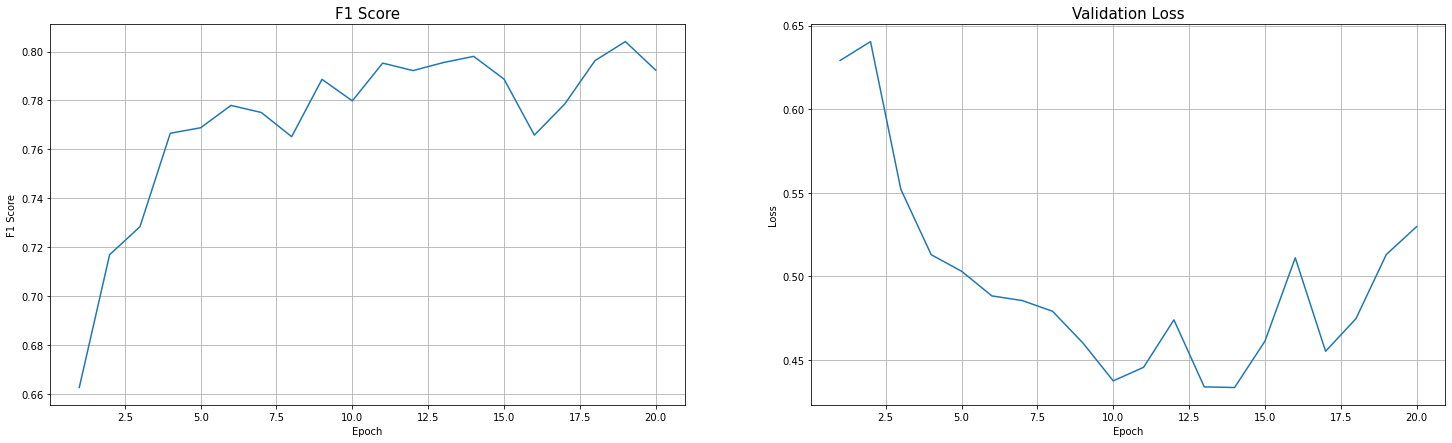

In [40]:
# your code
fig, ax = plt.subplots(1, 2, figsize=(25, 7))
ax[0].set_title("F1 Score", fontsize=15)
ax[0].plot(list(range(1, len(val_f1scores)+1)), val_f1scores)
ax[0].set_ylabel("F1 Score")
ax[0].set_xlabel("Epoch")
ax[0].grid(True)
ax[1].set_title("Validation Loss", fontsize=15)
ax[1].plot(list(range(1, len(val_losses)+1)), val_losses)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].grid(True)